<a href="https://colab.research.google.com/github/DenZhid/TelecommunicationSystemsLabs/blob/main/Lab6/Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Упражнение 6.1**

В этой главе утверждается, что *analyze1* требует времени пропорционально *$n^3$*, а *analyze2* - пропорционально *$n^2$*. Убедитесь в этом, запуская их с несколькими разными массивами и засекая время работы. В блокнотах Jupyter можно использовать "волшебную команду" **%timeit**.

Если печатать зависимость времени работы от размера на логарифмической шкале, то получится прямая линия с уклоном 3 для *analyze1* и с уклоном 2 для *analyze2*.

Также стоит поупражняться с *dct_iv* и *scipy.fftpack.dct*.

**Ход работы**

In [46]:
import os
import scipy.fftpack
import timeit
import numpy as np
import matplotlib.pyplot as plt

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

from scipy.stats import linregress
from thinkdsp import decorate, read_wave
from thinkdsp import Spectrogram, UncorrelatedGaussianNoise

if not os.path.exists('338986__drfx__music-box-melody-1.wav'):
    !wget https://github.com/DenZhid/TelecommunicationSystemsLabs/raw/main/Lab6/resources/338986__drfx__music-box-melody-1.wav

--2022-05-23 11:31:49--  https://github.com/DenZhid/TelecommunicationSystemsLabs/raw/main/Lab6/resources/338986__drfx__music-box-melody-1.wav
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DenZhid/TelecommunicationSystemsLabs/main/Lab6/resources/338986__drfx__music-box-melody-1.wav [following]
--2022-05-23 11:31:49--  https://raw.githubusercontent.com/DenZhid/TelecommunicationSystemsLabs/main/Lab6/resources/338986__drfx__music-box-melody-1.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2834042 (2.7M) [audio/wav]
Saving to: ‘338986__drfx__music-box-melody-1.wav’

338986__drfx__music 100%[==

Для начала напишем функции, реализующие *analyze1* и *analyze2*.

In [8]:
PI2 = np.pi * 2

def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

Также напишем функцию апроксимирующую результаты к прямой линии и замеряющую время работы для удобства анализа.

In [22]:
def plot_bests(ns, bests):    
    plt.plot(ns, bests)
    decorate(**dict(xscale='log', yscale='log'))
    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]
    return slope

def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = noise.ys[:N]
        result = timeit.timeit(lambda: func(ys, freqs, ts), number=1)
        results.append(result)
    bests = [result for result in results]
    return bests

Наконец произведём замеры времени для слеюущего массива *ns* и шумового сигнала.

64
128
256
512
1024
2048
4096


1.4941101359056275

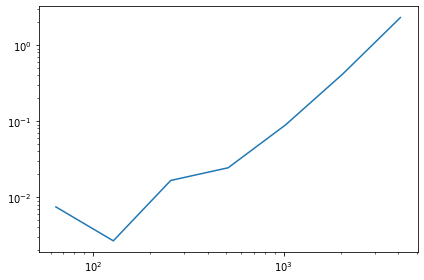

In [23]:
signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
ns = 2 ** np.arange(6, 13)

bests = run_speed_test(ns, analyze1)
plot_bests(ns, bests)

Расчетный наклон близок к 2, а не к 3, как ожидалось.

64
128
256
512
1024
2048
4096


1.4670119140083777

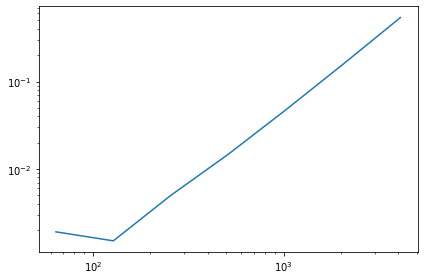

In [24]:
bests2 = run_speed_test(ns, analyze2)
plot_bests(ns, bests2)

Как и ожидалось, результаты укладываются в линию с расчетным наклоном, близким к 2.

Для примера также возьмём результаты для *scipy.fftpack.dct*

64
128
256
512
1024
2048
4096


-0.598005561043858

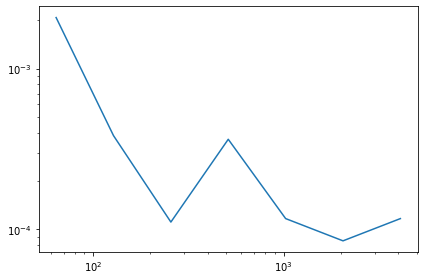

In [34]:
def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)

bests3 = run_speed_test(ns, scipy_dct)
plot_bests(ns, bests3)

Эта реализация dct еще быстрее. Линия сильно изогнута, что означает, что либо мы еще не видели асимптотику, либо асимптотика не является простым показателем n.

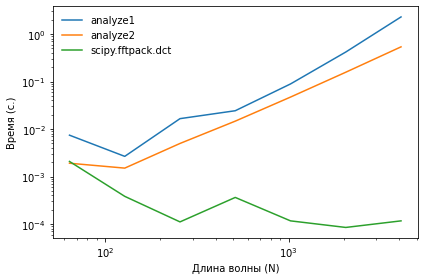

In [35]:
plt.plot(ns, bests, label='analyze1')
plt.plot(ns, bests2, label='analyze2')
plt.plot(ns, bests3, label='scipy.fftpack.dct')
decorate(xlabel='Длина волны (N)', ylabel='Время (с.)', **dict(xscale='log', yscale='log'))

# **Упражнение 6.2**

Одно из основных применений ДКП - это *сжатие* звука и изображений. В простейшей форме ДКП при сжатии работает следующим образом:
1.   Разбивает длинный сигнал на сегменты.
2.   Вычисляет ДКП каждого сегмента.
3.   Определяет частотные компоненты с такой амплитудой, что их не слышно, и удаляет их, сохраняя только оставшиеся частоты и амплитуды.
4.   При воспроизведении сигнала загружает частоты и амплитуды каждого сегмента и применяет обратное ДКП.

Реализуйте версию этого алгоритма и примените его для записи музыки или речь. Сколько компонент можно удалить до того, как разница станет заметной?

Для того, чтобы этот метод стал практичным, нужен  способ хранения *прореженного массива*, то есть массива, где большинство элементов равно нулю. NumPy (SciPy) дает несколько способов работы с прореженными массивами; о них можно прочитать на веб-странице [http://docs.scipy.org//doc/scipy/reference/sparse.html](http://docs.scipy.org//doc/scipy/reference/sparse.html)



**Ход работы**

В качестве тестируемого звука буду использовать музыку игрушечной шкатулки из первой лабораторной работы.

In [47]:
wave = read_wave('338986__drfx__music-box-melody-1.wav')
wave.make_audio()

Для начала возьмём небольшой сегмент в начале и расмотрим его ДКП.

In [48]:
segment = wave.segment(start=1.2, duration=0.5)
segment.normalize()
segment.make_audio()

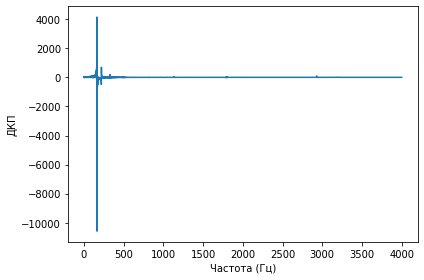

In [58]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate(xlabel='Частота (Гц)', ylabel='ДКП')

Как мы видим в звуке преобладает только одна гармоника и есть несколько, которые близки к нулю.

Напишем функцию *compress*, которая принимает ДКП и выставляет элементы ниже определённого значения в ноль.

In [60]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1
            
    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

Применим её на нашем сегменте.

21550	22050	97.73242630385488


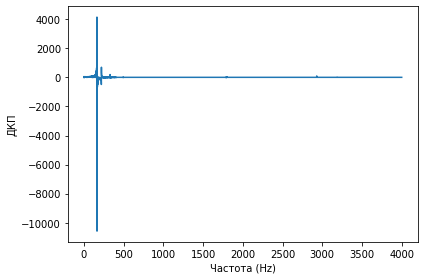

In [61]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=10)
seg_dct.plot(high=4000)
decorate(xlabel='Частота (Hz)', ylabel='ДКП')

Видим, что срезалось около 97% элементов, хотя звук остался примерно тем же (только стал чуть более глухим, как мне кажется).

In [62]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

Для сжатия более длинных сегментов, сделаем спектрограмму ДКП. Следующая функция похожа на функцию спектрограммы для волны, но использует она ДКП.

In [53]:
def make_dct_spectrogram(wave, seg_length):
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2
    spec_map = {}
    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)
        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

Применим её на всю нашу запись.

In [54]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.2)

1024	1024	100.0
821	1024	80.17578125
680	1024	66.40625
774	1024	75.5859375
810	1024	79.1015625
877	1024	85.64453125
887	1024	86.62109375
913	1024	89.16015625
915	1024	89.35546875
903	1024	88.18359375
914	1024	89.2578125
909	1024	88.76953125
926	1024	90.4296875
931	1024	90.91796875
922	1024	90.0390625
942	1024	91.9921875
953	1024	93.06640625
955	1024	93.26171875
947	1024	92.48046875
951	1024	92.87109375
963	1024	94.04296875
956	1024	93.359375
960	1024	93.75
960	1024	93.75
961	1024	93.84765625
961	1024	93.84765625
972	1024	94.921875
963	1024	94.04296875
977	1024	95.41015625
974	1024	95.1171875
974	1024	95.1171875
971	1024	94.82421875
975	1024	95.21484375
961	1024	93.84765625
979	1024	95.60546875
970	1024	94.7265625
980	1024	95.703125
973	1024	95.01953125
967	1024	94.43359375
971	1024	94.82421875
969	1024	94.62890625
967	1024	94.43359375
972	1024	94.921875
976	1024	95.3125
976	1024	95.3125
980	1024	95.703125
972	1024	94.921875
975	1024	95.21484375
940	1024	91.796875
880	1024	85.9375
906	1

Сжатие для большинства сегментов варьируется от 80 до 90%.
Послушаем полученный звук.

In [55]:
wave2 = spectro.make_wave()
wave2.make_audio()

Не считая некоторых трещаний звк очень похож на начальный.

# **Упражнение 6.3**

В репозитории этой книги есть блокнот Jupyter под названием *phase.ipynb*, в котором исследуется влияние фазы на восприятие звука. Прочтите блокнот и "погоняйте" примеры. Выберите иной сегмент звука и повторите эксперименты. Можно ли найти некие общие соотношения в фазовой структуре звука и его восприятии?